In [2]:
from string import Template
from functools import wraps

import numpy as np
import pandas as pd

from requests import Session

In [3]:
# .env variables / Config Files
mode = 'prod' # 'test' or 'prod'

URL = {
    'test': 'https://sandbox.iexapis.com/stable',
    'prod': 'https://cloud.iexapis.com/stable',
}

PUBLIC_TOKEN = {
    'test': 'Tpk_014e57ad96e94b69b9de1f4a987829ff',
    'prod': 'pk_5e1051685cca40bdac58b98b417d526d',
}

SECRET_URL = {
    'test': 'Tsk_0c4b8f624f7e4ed2ac36ee422705797f',
    'prod': 'sk_c699b92eaee247b7803de8b79727adc3',
}

In [4]:
base_url = URL[mode]
token_params = {
    'token': PUBLIC_TOKEN[mode],
}

REQUEST_API = {
    'exchanges': '/ref-data/exchanges',
    'region_scripts': '/ref-data/region/$region/symbols',
    'exchange_scripts': '/ref-data/exchange/$exchange/symbols',
    'crypto_symbols': '/ref-data/crypto/symbols',
    'historical': '/stock/$symbol/chart/$range',
}

PARAM_DICT = {
    'get_historical_olhc_adjusted': {
        'chartCloseOnly':'true',
    },
}

In [5]:
def get_data(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        url = func(*args, **kwargs)
        specific_params = PARAM_DICT.get(func.__name__,{})
        with Session() as s:
            r = s.get(url, params={**token_params, **specific_params})
            if r.status_code != 200:
                raise Exception(f'{r.status_code} error - {r.content}')
            return pd.json_normalize(r.json())
    return wrapper

In [6]:
@get_data
def get_exchanges():
    return base_url + REQUEST_API['exchanges']

@get_data
def get_crypto_symbols():
    return base_url + REQUEST_API['crypto_symbols']

@get_data
def get_exchange_scripts(exchange_id='nse'):
    return base_url + Template(REQUEST_API['exchange_scripts']).substitute(exchange=exchange_id)

@get_data
def get_region_scripts(region_id='in'):
    return base_url + Template(REQUEST_API['region_scripts']).substitute(region=region_id)

@get_data
def get_historical_olhc_adjusted(symbol):
    return base_url + Template(REQUEST_API['historical']).substitute(symbol=symbol, range='max')



In [10]:
# exchanges = get_exchanges()
# exchanges.to_pickle('data/exchange_list_iex.pkl')

# crypto = get_crypto_symbols()
# crypto.to_pickle('data/crypto_list_iex.pkl')

# nse_scripts = get_exchange_scripts(exchange_id='nse')
# nse_scripts.to_pickle('data/nse_scripts_iex.pkl')


In [12]:
stock1 = pd.read_pickle('data/nse_scripts_iex.pkl').symbol[0]
stock1

'E1ABFRLPP-IS'

In [13]:
stock_data = get_historical_olhc_adjusted(stock1)

<AxesSubplot:xlabel='date'>

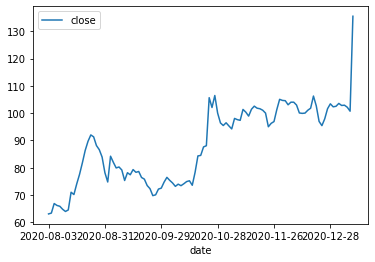

In [20]:
stock_data.set_index('date')[['close']].plot()

In [122]:
GET = Template(REQUEST_API['historical']).substitute(region='in', exchange='nse', symbol='E1ABFRLPP-IS', range='max')
specific_params = {
    'chartCloseOnly':'true'
}

r = requests.get(BASE_URL + GET, params={**token_params, **specific_params})

In [104]:
r.url

'https://sandbox.iexapis.com/stable/stock/E1ABFRLPP-IS/chart/max?token=Tpk_014e57ad96e94b69b9de1f4a987829ff&chartCloseOnly=true'

In [105]:
BASE_URL + GET

'https://sandbox.iexapis.com/stable/stock/E1ABFRLPP-IS/chart/max'

In [106]:
exchanges = pd.json_normalize(r.json())

In [107]:
exchanges

,date,close,volume,change,changePercent,changeOverTime
0,2020-08-03,63.94,195240,0.000000,0.0000,0.000000
1,2020-08-04,64.41,147292,0.314886,0.0049,0.004913
2,2020-08-05,69.50,181318,3.533409,0.0555,0.062370
3,2020-08-06,69.02,40036,-0.732253,-0.0106,0.050015
4,2020-08-07,66.97,69186,-0.308066,-0.0047,0.045303
...,...,...,...,...,...,...
104,2021-01-01,106.80,53673,-0.780000,-0.0073,0.650429
105,2021-01-04,105.20,58411,0.104720,0.0010,0.661735
106,2021-01-05,103.17,97572,-0.780000,-0.0073,0.637286
107,2021-01-06,101.60,69429,-1.485295,-0.0146,0.598522
